# ゼロの多い統計データのはなし -statsmodelを添えて-

こんにちは。EEIC2012→IST2014のdddddmmmmmです。よろしくお願いします。
新卒で半年だけ某SI企業に務めましたが、仕事が面白くなさすぎて辞めて、今の会社が拾ってくれて毎日ハッピーにデータ解析のお仕事をやっています。
人はわたしのことを物理屋崩れのアウトロー野郎と呼びます。嘘です。


本当は量子アニーリングのことを書こうと思ったのですが、論文通りのシミュレーションで結果が喜ばしくなかったのでバグってる可能性も捨てきれず、塩漬けしました。
バグ取りとか考えるともうちょっと時間長めに取るべきでしたね。
私の人生はだいたいそんな感じです。竜頭蛇尾というか。人生自体も竜頭蛇尾で個々のイベントの時系列を見ても竜頭蛇尾みたいな。階層構造だ。

今日は本職になって三ヶ月目であるところの統計のお話をしましょう。
大学六年間も通って書くのがやってみた系Advent Calenderになってしまうのは心苦しいですがお許しください。
"へえ〜こんなんでデータサイエンティストやれるんや　うちもなったろ"という方は連絡お待ちしております。上司に言ってみます。

さて、IT企業で解析をやっていると、ものすご0が多いデータなんかにたまに出くわします。
そういうときに使えるらしいzero-inflated poisson regressionについて今日はちょっとお話します。


# 使うデータについて


https://data.qld.gov.au/dataset/crash-data-from-queensland-roads/resource/dd13a889-2a48-4b91-8c64-59f824ed3d2c
を使用します。

交通事故のデータです。

中身を見ましょう。



In [3]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
df = pd.read_csv('driverdemographics.csv')

In [5]:
df

,Crash_Year,Crash_Police_Region,Crash_Severity,Involving_Male_Driver,Involving_Female_Driver,Involving_Young_Driver_16-24,Involving_Senior_Driver_60plus,Involving_Provisional_Driver,Involving_Overseas_Licensed_Driver,Involving_Unlicensed_Driver,Count_Crashes,Count_Casualty_Fatality,Count_Casualty_Hospitalised,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_All
0,2001,Brisbane,Fatal,No,No,No,No,No,No,No,1,1,0,0,0,1
1,2001,Brisbane,Fatal,No,Yes,No,No,No,No,No,5,5,1,0,0,6
2,2001,Brisbane,Fatal,No,Yes,No,Yes,No,No,No,4,4,0,2,0,6
3,2001,Brisbane,Fatal,No,Yes,No,Yes,No,No,Yes,1,1,0,0,0,1
4,2001,Brisbane,Fatal,No,Yes,No,Yes,Yes,No,No,1,1,1,0,0,2
5,2001,Brisbane,Fatal,No,Yes,Yes,No,No,No,No,1,1,1,0,0,2
6,2001,Brisbane,Fatal,No,Yes,Yes,No,Yes,No,No,2,2,0,1,0,3
7,2001,Brisbane,Fatal,Yes,No,No,No,No,No,No,9,10,0,0,0,10
8,2001,Brisbane,Fatal,Yes,No,No,No,No,No,Yes,5,5,3,0,0,8
9,2001,Brisbane,Fatal,Yes,No,No,No,Yes,No,No,2,3,0,0,0,3


まあ大体わかりますよね。
要は事故のデータで、怪我の度合いでランクが5つあって、事故に関わった運転手のデモグラがくっついてるみたいなデータです。
さて、興味があるのは0が多いデータなので、0を数えましょう。

In [31]:
df[df==0].count()

Crash_Year                               0
Crash_Police_Region                      0
Crash_Severity                           0
Involving_Male_Driver                    0
Involving_Female_Driver                  0
Involving_Young_Driver_16-24             0
Involving_Senior_Driver_60plus           0
Involving_Provisional_Driver             0
Involving_Overseas_Licensed_Driver       0
Involving_Unlicensed_Driver              0
Count_Crashes                            0
Count_Casualty_Fatality               9996
Count_Casualty_Hospitalised           7772
Count_Casualty_MedicallyTreated       6864
Count_Casualty_MinorInjury            6394
Count_Casualty_All                    2475
dtype: int64

いい感じにゼロが多そうなので、今回の目標は、Count_Crashを母集団として、Casualty Fatality(命に関わる死傷者)が生じるのに効いたInvolving_hogehogeなど(あとyearとregionね)は何か、ということにしましょう。

In [20]:
#とりあえず眺める
df.describe()

,Crash_Year,Involving_Male_Driver,Involving_Female_Driver,Involving_Young_Driver_16-24,Involving_Senior_Driver_60plus,Involving_Provisional_Driver,Involving_Overseas_Licensed_Driver,Involving_Unlicensed_Driver,Count_Crashes,Count_Casualty_Fatality,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_All,Brisbane,Central,Northern,South Eastern,Southern,Unknown,Const
count,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,...,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.000000,11180.0
mean,2006.377102,0.710555,0.605814,0.509213,0.343202,0.317710,0.171288,0.262075,22.853131,0.383721,...,7.700268,4.702952,20.036315,0.212701,0.204562,0.181306,0.195796,0.183810,0.021825,1.0
std,3.521700,0.453525,0.488697,0.499937,0.474800,0.465607,0.376777,0.439783,47.511193,1.933315,...,29.434842,16.569880,45.601295,0.409236,0.403399,0.385289,0.396830,0.387347,0.146117,0.0
min,2001.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,2006.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,2009.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,21.000000,0.000000,...,2.000000,2.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,485.000000,42.000000,...,480.000000,318.000000,513.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [21]:
#適当に前処理
pd.get_dummies(df['Crash_Police_Region'])
df = df.replace('Yes',1)
df = df.replace('No',0)
df[['Brisbane','Central','Northern','South Eastern','Southern','Unknown']] = pd.get_dummies(df['Crash_Police_Region'])
df['Const'] = sm.add_constant(df.Brisbane)['const']

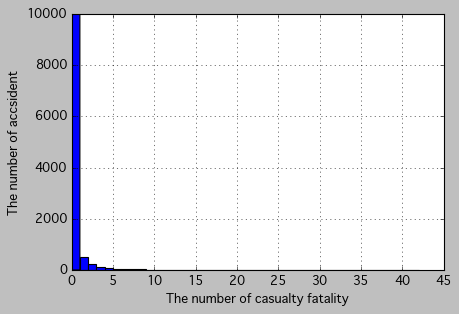

In [22]:
#適当に可視化
fig,ax = plt.subplots(1,1)
df['Count_Casualty_Fatality'].hist(bins=df['Count_Casualty_Fatality'].max())
ax.set_xlabel('The number of casualty fatality')
ax.set_ylabel('The number of accsident')

# poisson regression


いい感じにゼロが多そうで安心しましたね。
さてさて、次は回帰に入りましょう。
まず、ポアソン回帰というやつをやります。

次のような仮定をおきます。
Casualty Fatalityの数$X$は、事故あたりに平均$\lambda$人である。

そうすると、事故あたりにCasualty Fatalityの数$X$が$k$人である確率は、次のように書けます。

$P(X = k) = \frac{\lambda^{k} e^{-\lambda}}{k!}$

$l$番目の事故についてのパラメータ$\lambda_{l}$は、その事故の特徴量$d_i$や$r_i$と、次の関係が存在しているとする。

${\rm log}(\lambda_{l}) = \sum_{i=1}^{N} \beta_{i} d_{i} + \sum_{i=1}^{M} \beta_{N+i} r_{i}$

平たくいうと、その事故に関わった運転手が男だった場合$d_{Involving　Male　Driver} = 1$になって、$\beta_{Involving　Male　Driver}$の正負で平均人数$\lambda$が大きくなったり小さくなったりしろ、ということを要請しています。

ただその効果は上のモデルだと俺は思っちゃうことにするぜ！という話です。

長々と喋りましたが、次のように簡単にできちゃいます。

In [23]:
fam = sm.families.Poisson()
y = df['Count_Casualty_Fatality']
X = df[['Crash_Year','Involving_Male_Driver',
                                                        'Involving_Female_Driver',
                                                        'Involving_Young_Driver_16-24',
                                                       'Involving_Senior_Driver_60plus',
                                                       'Involving_Provisional_Driver',
                                                       'Involving_Overseas_Licensed_Driver',
                                                       'Involving_Unlicensed_Driver',
                                                        'Brisbane',
                                                     'Central',
                                                     'Northern',
                                                     'South Eastern',
                                                     'Southern',
                                                     'Unknown',
                                                     'Const']]
model1 = sm.GLM(y,X,family=fam)
result1 = model1.fit()
print(result1.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Count_Casualty_Fatality   No. Observations:                11180
Model:                                 GLM   Df Residuals:                    11166
Model Family:                      Poisson   Df Model:                           13
Link Function:                         log   Scale:                             1.0
Method:                               IRLS   Log-Likelihood:                -10002.
Date:                     Wed, 07 Dec 2016   Deviance:                       16750.
Time:                             23:39:14   Pearson chi2:                 3.85e+04
No. Iterations:                         10                                         
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Crash_Year                            

In [32]:
#aic/bicを計算 model間でいい感じかどうかの比較をするための数値　使えるかどうかは場合によるので注意　教科書を読みながらやろう
print('aic: ',result1.aic)
print('bic: ',result1.bic)

aic:  20031.3491438
bic:  -87337.7581945


In [33]:
#muには回帰結果が入っていることを確認
print(result1.mu[0],np.exp((result1.params.values*X.ix[0].values).sum()),y[0])

0.557959236738 0.557959236738 1


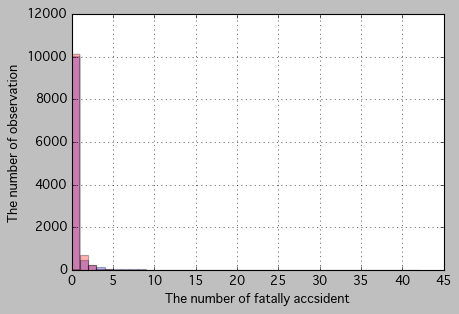

In [34]:
fig,ax = plt.subplots(1,1)
df['Count_Casualty_Fatality'].hist(bins = max(df['Count_Casualty_Fatality']),alpha=0.3)
dfbuf = pd.DataFrame()
dfbuf['mu'] = result1.mu
dfbuf['mu'].hist(color='r',alpha=0.3,bins=max(df['Count_Casualty_Fatality']),range=(0,max(df['Count_Casualty_Fatality'])))
ax.set_xlabel('The number of fatally accsident')
ax.set_ylabel('The number of observation')

なんということでしょう。
回帰できてしまっている感じがしますね。
しかし、これじゃネタになりません。

In [35]:
print(result1.mu.mean())
print(result1.mu.var())
print(df['Count_Casualty_Fatality'].values.mean())
print(df['Count_Casualty_Fatality'].values.var())

0.383721295691
0.410290628374
0.383720930233
3.73737363232


計算してみると、どうも元データは分散が大きいようです。本当は最初に気づくべきですね。こういうデータの性質を過分散、overdispersionといいます。

ポアソン分布は平均も分散も$\lambda$になってくれるという性質があるので、そもそもポアソン分布で説明すんのちょっと微妙だな〜と思い始めましょう。繰り返しますが、本当は最初に気づくべきです。本来は平均も分散も近しい値っぽいしポアソン分布じゃね？と思うのが筋だそうです。

あとまあ、一個の分布だけでフィッティングしてなんか回帰できてるっぽいしオッケー♡というのもアホっぽいですね。

幾つか言い訳もたったことですし、過分散を補償できる負の二項分布での回帰を考えましょう。

In [67]:
fam = sm.families.NegativeBinomial()
y = df['Count_Casualty_Fatality']
X = df[['Crash_Year','Involving_Male_Driver',
                                                        'Involving_Female_Driver',
                                                        'Involving_Young_Driver_16-24',
                                                       'Involving_Senior_Driver_60plus',
                                                       'Involving_Provisional_Driver',
                                                       'Involving_Overseas_Licensed_Driver',
                                                       'Involving_Unlicensed_Driver',
                                                        'Brisbane',
                                                     'Central',
                                                     'Northern',
                                                     'South Eastern',
                                                     'Southern',
                                                     'Unknown',
                                                     'Const']]
model2 = sm.GLM(y,X,family=fam)
result2 = model2.fit()
print(result2.summary())

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Count_Casualty_Fatality   No. Observations:                11180
Model:                                 GLM   Df Residuals:                    11166
Model Family:             NegativeBinomial   Df Model:                           13
Link Function:                         log   Scale:                   2.12610490609
Method:                               IRLS   Log-Likelihood:                -6875.4
Date:                     Tue, 06 Dec 2016   Deviance:                       8889.9
Time:                             08:28:10   Pearson chi2:                 2.37e+04
No. Iterations:                         26                                         
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Crash_Year                            

In [68]:
print('aic: ',result2.aic)
print('bic: ',result2.bic)

aic:  13778.8669159
bic:  -95198.2725437


In [69]:
print(result2.mu.mean())
print(result2.mu.var())
print(df['Count_Casualty_Fatality'].values.mean())
print(df['Count_Casualty_Fatality'].values.var())

0.37460139991
0.340182808113
0.383720930233
3.73737363232


NameError: name 'result2' is not defined

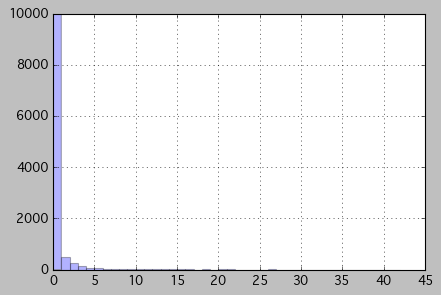

In [10]:
fig,ax = plt.subplots(1,1)
df['Count_Casualty_Fatality'].hist(bins = max(df.Count_Casualty_Fatality),alpha=0.3)
dfbuf = pd.DataFrame()
dfbuf['mu'] = result2.mu
dfbuf['mu'].hist(color='r',alpha=0.3,bins=max(df.Count_Casualty_Fatality),range=(0,max(df.Count_Casualty_Fatality)))
ax.set_xlabel('The number of fatally accsident')
ax.set_ylabel('The number of observation')